# Assignment Solution: Data Quality Assessment & Preprocessing (Telco Customer Churn)

This notebook solves the assignment tasks using **Dataset.xlsx**.

## Tasks
1. Identify data quality issues in the dataset  
2. Apply one missing value strategy and explain why  
3. Detect and handle outliers using IQR  
4. Normalize numerical features using both Min-Max and Z-score  
5. Apply PCA and interpret explained variance


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

## 1) Load Dataset

In [10]:
df_raw = pd.read_excel("Dataset.xlsx")
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Task 1 — Identify Data Quality Issues

We will check:
- data types
- missing values
- duplicate rows / duplicate IDs
- hidden missing values stored as blank strings (especially in `TotalCharges`)


In [11]:
# Basic quality checks
print("Data types:")
display(df_raw.dtypes)

print("\nDuplicate rows:", df_raw.duplicated().sum())
print("Duplicate customerID:", df_raw["customerID"].duplicated().sum())

print("\nMissing values (before conversion):")
display(df_raw.isna().sum().sort_values(ascending=False).to_frame("missing_count").query("missing_count > 0"))

# Check blank strings in object columns
blank_summary = {}
for col in df_raw.select_dtypes(include="object").columns:
    blank_count = df_raw[col].astype(str).str.strip().eq("").sum()
    if blank_count > 0:
        blank_summary[col] = int(blank_count)

print("\nBlank-string values in object columns:")
blank_summary

Data types:


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Duplicate rows: 0
Duplicate customerID: 0

Missing values (before conversion):


,missing_count



Blank-string values in object columns:


{'TotalCharges': 11}

In [12]:
# Convert TotalCharges to numeric (blank strings -> NaN)
df = df_raw.copy()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

print("Missing values after converting TotalCharges:")
display(df.isna().sum().sort_values(ascending=False).to_frame("missing_count").query("missing_count > 0"))

# Inspect rows with missing TotalCharges
df[df["TotalCharges"].isna()][["customerID", "tenure", "MonthlyCharges", "TotalCharges"]].head(15)

Missing values after converting TotalCharges:


,missing_count
TotalCharges,11


,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN
3331,7644-OMVMY,0,19.85,NaN
3826,3213-VVOLG,0,25.35,NaN
4380,2520-SGTTA,0,20.00,NaN
5218,2923-ARZLG,0,19.70,NaN
6670,4075-WKNIU,0,73.35,NaN


### Task 1 Findings (Summary)
- Dataset has **7043 rows** and **21 columns**
- Duplicate rows: **0**
- Duplicate `customerID`: **0**
- Main issue: `TotalCharges` is read as **object** due to blank strings
- After conversion, `TotalCharges` contains **11 missing values (NaN)**

> These are hidden missing values and must be handled before preprocessing/modeling.


## 3) Task 2 — Missing Value Strategy (and Why)

### Chosen strategy: **Domain-aware imputation**
For this Telco dataset, missing values in `TotalCharges` happen for customers with `tenure = 0` (new customers).
That means their total accumulated charges should logically be **0**.

**Why this is better than mean/median here:**
- It preserves business meaning
- It avoids injecting artificial spending values into new customers
- It is more accurate than generic statistical imputation for this specific case


In [13]:
df_clean = df.copy()

# Fill missing TotalCharges with 0 only when tenure == 0 (domain-aware)
mask = df_clean["TotalCharges"].isna() & (df_clean["tenure"] == 0)
df_clean.loc[mask, "TotalCharges"] = 0.0

# Defensive fallback (should not be needed in this dataset)
if df_clean["TotalCharges"].isna().sum() > 0:
    df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(df_clean["TotalCharges"].median())

print("Remaining missing values in TotalCharges:", df_clean["TotalCharges"].isna().sum())
df_clean[["tenure", "MonthlyCharges", "TotalCharges"]].head()

Remaining missing values in TotalCharges: 0


,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Filled rows using domain-aware rule (`tenure == 0` → `TotalCharges = 0`): **11**  
Remaining missing values in `TotalCharges`: **0**


## 4) Task 3 — Detect and Handle Outliers Using IQR

We will apply the **IQR method** on the main continuous numerical features:
- `tenure`
- `MonthlyCharges`
- `TotalCharges`

### IQR rule
A value is considered an outlier if:
- `< Q1 - 1.5 × IQR` or
- `> Q3 + 1.5 × IQR`

### Handling approach
We use **IQR capping (winsorization)**:
- values below lower bound are clipped to lower bound
- values above upper bound are clipped to upper bound


In [14]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
df_iqr = df_clean.copy()

iqr_summary = []

for col in num_cols:
    q1 = df_iqr[col].quantile(0.25)
    q3 = df_iqr[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_mask = (df_iqr[col] < lower) | (df_iqr[col] > upper)
    outlier_count = int(outlier_mask.sum())

    before = df_iqr[col].copy()
    df_iqr[col] = df_iqr[col].clip(lower, upper)
    capped_count = int((before != df_iqr[col]).sum())

    iqr_summary.append({
        "feature": col,
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "lower_bound": lower,
        "upper_bound": upper,
        "outlier_count": outlier_count,
        "capped_count": capped_count
    })

iqr_summary_df = pd.DataFrame(iqr_summary)
iqr_summary_df

,feature,Q1,Q3,IQR,lower_bound,upper_bound,outlier_count,capped_count
0,tenure,9.00,55.00,46.00,-60.000,124.000,0,0
1,MonthlyCharges,35.50,89.85,54.35,-46.025,171.375,0,0
2,TotalCharges,398.55,3786.60,3388.05,-4683.525,8868.675,0,0


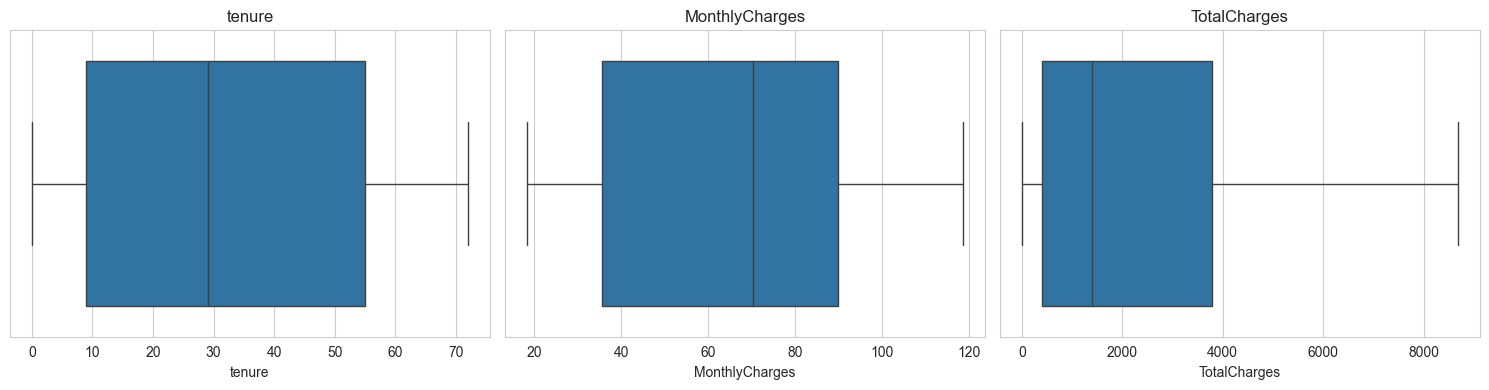

In [15]:
# Boxplots after handling (for visual check)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ["tenure", "MonthlyCharges", "TotalCharges"]):
    sns.boxplot(x=df_iqr[col], ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

### Task 3 Result
- Total outliers detected across selected features (using standard **1.5×IQR**): **0**
- If `capped_count = 0`, it means the feature had **no outliers under the IQR rule**, so the data remains unchanged for that feature.

This is a valid outcome and should be reported clearly.


## 5) Task 4 — Normalize Numerical Features (Min-Max and Z-score)

We normalize the same continuous numerical features:
- `tenure`
- `MonthlyCharges`
- `TotalCharges`


In [16]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Min-Max normalization
minmax_scaler = MinMaxScaler()
df_minmax = df_iqr.copy()
df_minmax[[f"{c}_MinMax" for c in num_cols]] = minmax_scaler.fit_transform(df_iqr[num_cols])

# Z-score normalization
zscore_scaler = StandardScaler()
df_zscore = df_iqr.copy()
df_zscore[[f"{c}_Z" for c in num_cols]] = zscore_scaler.fit_transform(df_iqr[num_cols])

print("Min-Max summary (should be between 0 and 1):")
display(df_minmax[[f"{c}_MinMax" for c in num_cols]].agg(["min", "max"]))

print("Z-score summary (mean ≈ 0, std ≈ 1):")
display(df_zscore[[f"{c}_Z" for c in num_cols]].agg(["mean", "std"]))

df_minmax[[f"{c}_MinMax" for c in num_cols]].head()

Min-Max summary (should be between 0 and 1):


,tenure_MinMax,MonthlyCharges_MinMax,TotalCharges_MinMax
min,0.0,0.0,0.0
max,1.0,1.0,1.0


Z-score summary (mean ≈ 0, std ≈ 1):


,tenure_Z,MonthlyCharges_Z,TotalCharges_Z
mean,-2.421273e-17,-6.406285e-17,-3.783239e-17
std,1.000071e+00,1.000071e+00,1.000071e+00


,tenure_MinMax,MonthlyCharges_MinMax,TotalCharges_MinMax
0,0.013889,0.115423,0.003437
1,0.472222,0.385075,0.217564
2,0.027778,0.354229,0.012453
3,0.625000,0.239303,0.211951
4,0.027778,0.521891,0.017462


### Notes
- **Min-Max** scales each feature into the range **[0, 1]**
- **Z-score** standardization centers data around **0** with standard deviation near **1**
- PCA is typically applied after **Z-score standardization**


## 6) Task 5 — PCA and Explained Variance

We apply PCA on the **standardized numerical features** (`tenure`, `MonthlyCharges`, `TotalCharges`) and interpret how much variance each principal component explains.


In [17]:
# Standardized matrix for PCA
X_std = zscore_scaler.fit_transform(df_iqr[num_cols])

pca = PCA()
X_pca = pca.fit_transform(X_std)

explained_variance_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(X_std.shape[1])],
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_explained_variance": np.cumsum(pca.explained_variance_ratio_)
})

loadings_df = pd.DataFrame(
    pca.components_.T,
    index=num_cols,
    columns=explained_variance_df["PC"]
)

display(explained_variance_df)
display(loadings_df)

,PC,explained_variance_ratio,cumulative_explained_variance
0,PC1,0.726888,0.726888
1,PC2,0.253258,0.980146
2,PC3,0.019854,1.000000


PC,PC1,PC2,PC3
tenure,0.567299,0.606784,0.556764
MonthlyCharges,0.485842,-0.792495,0.368658
TotalCharges,0.664928,0.061360,-0.744383


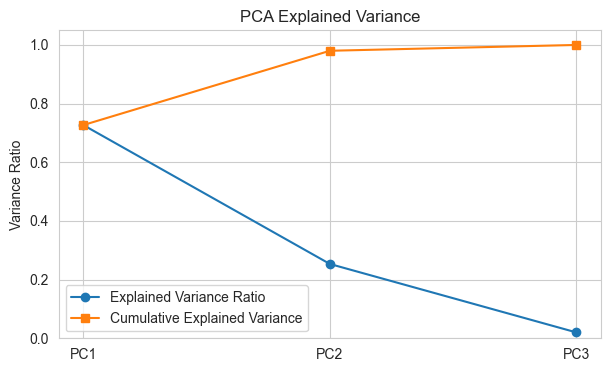

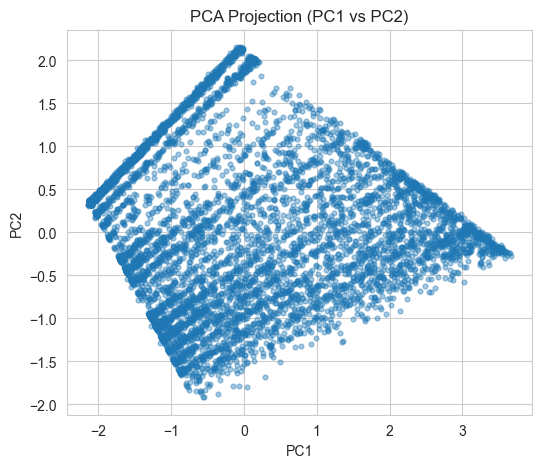

In [18]:
# Scree + cumulative explained variance
plt.figure(figsize=(7,4))
plt.plot(explained_variance_df["PC"], explained_variance_df["explained_variance_ratio"], marker="o", label="Explained Variance Ratio")
plt.plot(explained_variance_df["PC"], explained_variance_df["cumulative_explained_variance"], marker="s", label="Cumulative Explained Variance")
plt.ylim(0, 1.05)
plt.title("PCA Explained Variance")
plt.ylabel("Variance Ratio")
plt.legend()
plt.show()

# PCA scatter (PC1 vs PC2)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4, s=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.show()

### PCA Interpretation (This Dataset)
- **PC1 explains 72.69%** of the variance.
- **PC1 + PC2 explain 98.01%** of the variance.
- This means the first **2 components** preserve almost all information in the 3 standardized numerical features.
- So dimensionality can be reduced from **3 features → 2 principal components** with minimal information loss.


## 7) Export Files for GitHub / Submission

The following exports are created:
- cleaned dataset (after missing value handling)
- IQR summary
- dataset after outlier handling
- Min-Max normalized version
- Z-score normalized version
- PCA explained variance and loadings
- PCA component scores


In [19]:
# Export output files
df_clean.to_csv("telco_preprocessing_results/01_telco_cleaned_missing_handled.csv", index=False)
iqr_summary_df.to_csv("telco_preprocessing_results/02_iqr_outlier_summary.csv", index=False)
df_iqr.to_csv("telco_preprocessing_results/03_telco_after_iqr_handling.csv", index=False)
df_minmax.to_csv("telco_preprocessing_results/04_telco_minmax_normalized.csv", index=False)
df_zscore.to_csv("telco_preprocessing_results/05_telco_zscore_normalized.csv", index=False)
explained_variance_df.to_csv("telco_preprocessing_results/06_pca_explained_variance.csv", index=False)
loadings_df.to_csv("telco_preprocessing_results/07_pca_loadings.csv")
pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]).to_csv("telco_preprocessing_results/08_pca_components_dataset.csv", index=False)

print("All output files saved successfully.")

All output files saved successfully.
